In [35]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [37]:
tf.keras.backend.clear_session()

In [38]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [39]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [40]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [41]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Rondônia - Desemprego
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,8.226062
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,8.219943
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,8.213823
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,8.207703
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.912133,1001.002826,1427.436424,26.821147,21.235681,81.687040,1.636692,20.931530,NaN,NaN,NaN,NaN,NaN,49.066,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.989077,1000.506556,1393.831619,26.844055,21.198468,81.832140,1.584472,20.812259,NaN,NaN,NaN,NaN,NaN,49.850,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.954101,1000.329052,1373.907702,26.671034,21.174764,81.851609,1.547382,20.687985,NaN,NaN,NaN,NaN,NaN,43.733,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.778823,1000.212511,1362.404593,26.567420,21.161783,81.874158,1.538540,20.551024,NaN,NaN,NaN,NaN,NaN,40.078,NaN


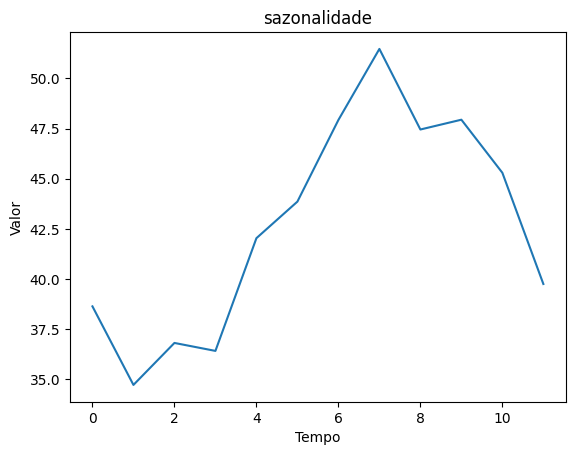

,sazonalidade
sazonalidade,
0,38.640150
1,34.725400
2,36.817425
3,36.420650
4,42.038250
5,43.860500
6,47.928850
7,51.469600
8,47.453850


In [42]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [43]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,8.226062,38.640150,13.867
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,8.219943,34.725400,10.777
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,8.213823,36.817425,13.888
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,8.207703,36.420650,11.859
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,8.201584,42.038250,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.912133,1001.002826,1427.436424,26.821147,21.235681,81.687040,1.636692,20.931530,NaN,NaN,NaN,NaN,NaN,NaN,51.469600,49.066
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.989077,1000.506556,1393.831619,26.844055,21.198468,81.832140,1.584472,20.812259,NaN,NaN,NaN,NaN,NaN,NaN,47.453850,49.850
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.954101,1000.329052,1373.907702,26.671034,21.174764,81.851609,1.547382,20.687985,NaN,NaN,NaN,NaN,NaN,NaN,47.942450,43.733
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.778823,1000.212511,1362.404593,26.567420,21.161783,81.874158,1.538540,20.551024,NaN,NaN,NaN,NaN,NaN,NaN,45.296950,40.078


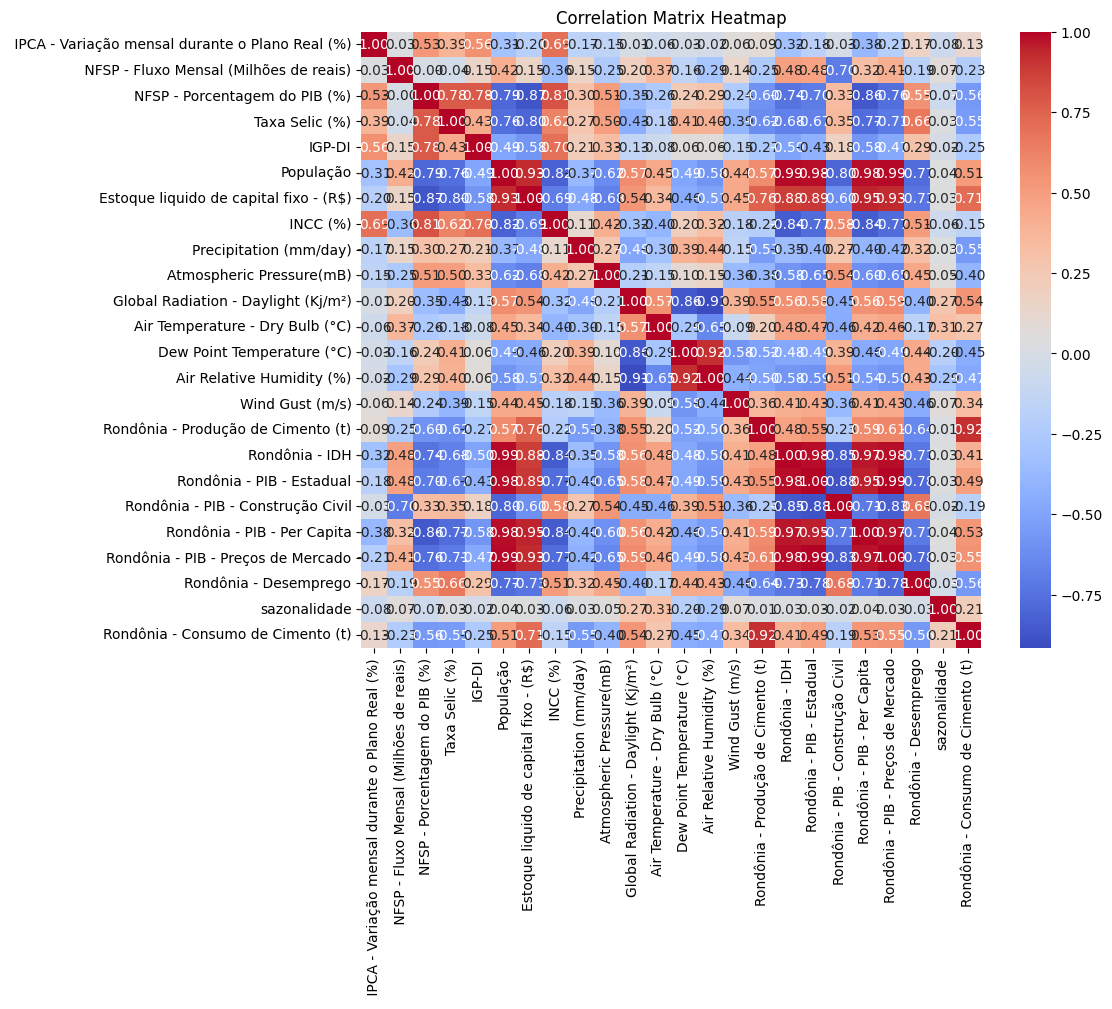

In [44]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [45]:
# data =data.drop([' NFSP - Fluxo Mensal (Milhões de reais)',
#                  'Air Temperature - Dry Bulb (°C)', 
#                  'Rio Grande do Norte - PIB - Construção Civil'], axis=1)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,4.987000,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,8.226062,38.640150,13.867
1,2003-2,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,4.987000,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,8.219943,34.725400,10.777
2,2003-3,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,4.987000,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,8.213823,36.817425,13.888
3,2003-4,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,4.987000,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,8.207703,36.420650,11.859
4,2003-5,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,4.987000,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,8.201584,42.038250,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.912133,1001.002826,1427.436424,26.821147,21.235681,81.687040,1.636692,20.931530,NaN,NaN,NaN,NaN,NaN,NaN,51.469600,49.066
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.989077,1000.506556,1393.831619,26.844055,21.198468,81.832140,1.584472,20.812259,NaN,NaN,NaN,NaN,NaN,NaN,47.453850,49.850
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.954101,1000.329052,1373.907702,26.671034,21.174764,81.851609,1.547382,20.687985,NaN,NaN,NaN,NaN,NaN,NaN,47.942450,43.733
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.778823,1000.212511,1362.404593,26.567420,21.161783,81.874158,1.538540,20.551024,NaN,NaN,NaN,NaN,NaN,NaN,45.296950,40.078


In [46]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade
0,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,0.356349,1.574393,-0.105391,-0.455840,-0.457664,-0.223971,0.008517,-1.115226,-1.859790,-1.684237,0.358666,-2.401614,-1.935575,1.247042,-0.778539
1,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.353303,1.567225,-0.103517,-0.454463,-0.457640,-0.224385,0.009909,-1.115226,-1.835964,-1.666360,0.383576,-2.358981,-1.906624,1.233793,-1.530033
2,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,0.351526,1.563044,-0.102423,-0.453659,-0.457627,-0.224626,0.010721,-1.115226,-1.812139,-1.648484,0.408485,-2.316347,-1.877673,1.220544,-1.128438
3,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,0.351335,1.562596,-0.102306,-0.453573,-0.457625,-0.224652,0.010808,-1.115226,-1.788313,-1.630607,0.433395,-2.273714,-1.848722,1.207295,-1.204605
4,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,0.361711,1.548847,-0.113005,-0.447464,-0.435657,-0.208842,-0.006535,-1.115226,-1.764487,-1.612730,0.458305,-2.231081,-1.819771,1.194046,-0.126224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,1.841752,0.213016,1.525704,1.371031,-1.120628,-1.518675,0.615733,-0.247503,1.280168,1.167829,-1.179294,1.068920,1.031159,-1.264706,1.684263
188,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,1.546764,0.209454,1.054348,1.182558,-0.819099,-1.203706,0.632199,-0.239967,1.265078,1.159325,-1.160375,1.051588,1.020921,-1.291394,0.913381
189,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.867088,0.234410,0.470777,0.752726,-0.476804,-0.748452,0.626943,-0.218298,1.249987,1.150821,-1.141456,1.034256,1.010683,-1.318081,1.007175
190,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.956642,0.258962,0.140343,0.398022,-0.283936,-0.446641,0.323510,-0.219108,1.234897,1.142317,-1.122538,1.016924,1.000446,-1.344769,0.499332


In [47]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      13.420
1      11.302
2      16.993
3      16.214
4      15.406
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 240, dtype: float64

In [48]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade
0,2.723741,0.364808,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,0.356349,1.574393,-0.105391,-0.455840,-0.457664,-0.223971,0.008517,-1.115226,-1.859790,-1.684237,0.358666,-2.401614,-1.935575,1.247042,-0.778539
1,2.350880,0.368956,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.353303,1.567225,-0.103517,-0.454463,-0.457640,-0.224385,0.009909,-1.115226,-1.835964,-1.666360,0.383576,-2.358981,-1.906624,1.233793,-1.530033
2,2.123016,0.331110,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,0.351526,1.563044,-0.102423,-0.453659,-0.457627,-0.224626,0.010721,-1.115226,-1.812139,-1.648484,0.408485,-2.316347,-1.877673,1.220544,-1.128438
3,2.021477,0.244570,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,0.351335,1.562596,-0.102306,-0.453573,-0.457625,-0.224652,0.010808,-1.115226,-1.788313,-1.630607,0.433395,-2.273714,-1.848722,1.207295,-1.204605
4,1.887113,0.279013,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,0.361711,1.548847,-0.113005,-0.447464,-0.435657,-0.208842,-0.006535,-1.115226,-1.764487,-1.612730,0.458305,-2.231081,-1.819771,1.194046,-0.126224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.214006,1.216560,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,1.042859,-0.826837,0.594273,0.960143,0.403840,-0.064220,-0.056853,-0.087019,1.457304,1.215933,-1.493457,1.031936,1.145432,-0.079052,-1.530033
158,-0.434717,1.155373,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,0.818609,-0.746263,0.513281,0.393282,0.203800,0.016266,-0.144623,-0.105967,1.457217,1.221174,-1.488264,1.051337,1.152213,-0.144286,-1.128438
159,-0.524091,1.056140,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,-0.194875,-0.531241,0.864065,0.173099,-0.330188,-0.287487,-0.215700,-0.124493,1.457130,1.226414,-1.483070,1.070737,1.158994,-0.209519,-1.204605
160,-0.614500,1.147619,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-0.976113,-0.263219,0.930982,-0.001553,-0.808982,-0.565890,-0.278254,-0.140092,1.457044,1.231655,-1.477877,1.090137,1.165775,-0.274753,-0.126224


In [49]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      13.420
1      11.302
2      16.993
3      16.214
4      15.406
        ...  
157    29.662
158    31.408
159    29.484
160    33.601
161    36.905
Name: Rondônia - Consumo de Cimento (t), Length: 162, dtype: float64

In [50]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [51]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 23)

In [52]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - Produção de Cimento (t),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Desemprego,sazonalidade
126,0.888984,-0.230612,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,-0.561373,-1.240562,1.013048,-0.964194,-1.142362,-0.523663,4.033533,1.079360,0.470813,0.768768,-0.731913,0.443163,0.775263,-1.186007,1.004564
127,0.954254,-0.156322,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,-0.369270,-2.243259,1.144423,-0.172977,-0.993427,-0.757347,3.254695,1.020528,0.487914,0.788783,-0.758573,0.464268,0.791970,-1.119247,1.684263
128,1.045217,-0.120008,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,-0.432881,-3.145644,0.926971,0.216266,-0.549766,-0.575762,2.494720,0.951051,0.505015,0.808798,-0.785233,0.485374,0.808677,-1.052486,0.913381
129,1.176395,-0.143194,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,-0.294886,-3.866085,0.685287,0.146555,-0.351809,-0.391348,1.768215,0.901602,0.522117,0.828813,-0.811893,0.506479,0.825384,-0.985725,1.007175
130,1.303259,-0.028712,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,0.117897,-4.189024,0.393059,0.273612,-0.234544,-0.356598,1.165224,0.847437,0.539218,0.848827,-0.838553,0.527585,0.842091,-0.918965,0.499332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,2.953658,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,1.841752,0.213016,1.525704,1.371031,-1.120628,-1.518675,0.615733,-0.247503,1.280168,1.167829,-1.179294,1.068920,1.031159,-1.264706,1.684263
188,-1.870713,3.351323,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,1.546764,0.209454,1.054348,1.182558,-0.819099,-1.203706,0.632199,-0.239967,1.265078,1.159325,-1.160375,1.051588,1.020921,-1.291394,0.913381
189,-1.806230,3.404908,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.867088,0.234410,0.470777,0.752726,-0.476804,-0.748452,0.626943,-0.218298,1.249987,1.150821,-1.141456,1.034256,1.010683,-1.318081,1.007175
190,-1.727496,3.671303,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.956642,0.258962,0.140343,0.398022,-0.283936,-0.446641,0.323510,-0.219108,1.234897,1.142317,-1.122538,1.016924,1.000446,-1.344769,0.499332


In [53]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 23)

In [54]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [55]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [56]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [57]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[4061981921, 4182993223, 2903575590, 590982040, 113445151, 388930046, 4159782459, 1471475403, 2367764489, 1205761285, 2312606593, 2150438378, 3690443619, 1172850144, 726623489, 1712273125, 3611513544, 4080415517, 4058816474, 1902392411, 627140999, 3436345612, 919457052, 951583038, 3185424105, 165402881, 2370091824, 117502966, 2743577892, 1763805164, 2939937491, 3855204106, 461355736, 1011079741, 4240782503, 2531663519, 3058136622, 3966277761, 713742566, 1055513988, 2447122550, 1818673415, 3759390338, 1479210455, 3969778310, 2435275210, 89341933, 3149411009, 122903562, 1753385449]


Step: 0 ___________________________________________
val_loss: 44.87416076660156
winner_seed: 4061981921


Step: 1 ___________________________________________
val_loss: 37.2678337097168
winner_seed: 4182993223


Step: 2 ___________________________________________
val_loss: 45.261112213134766


Step: 3 ___________________________________________
val_loss: 38.58291244506836


Step: 4 ___________________________

In [58]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 138ms/step - loss: 2907.0427 - val_loss: 749.8087
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 607.7000 - val_loss: 562.5311
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 484.2371 - val_loss: 524.1941
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 548.3456 - val_loss: 419.8712
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 311.9139 - val_loss: 1377.6783
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 816.8878 - val_loss: 506.5693
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 570.8083 - val_loss: 557.0760
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 395.1999 - val_loss: 237.2934
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 230.1697 - val_loss: 318.9077
Epoch 10/10000
4/4 [==============================] - 0s 12ms

Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 40.1633 - val_loss: 73.5482
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 45.0541 - val_loss: 108.9114
Epoch 82/10000
4/4 [==============================] - 0s 12ms/step - loss: 45.1270 - val_loss: 86.8830
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.4427 - val_loss: 67.1631
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 44.1317 - val_loss: 66.8070
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.4160 - val_loss: 68.1114
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 50.7498 - val_loss: 67.2840
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.4030 - val_loss: 81.8738
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 41.2633 - val_loss: 78.3242
Epoch 89/10000
4/4 [==============================] - 0s 11ms/step - los

Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.3033 - val_loss: 85.5344
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 27.7990 - val_loss: 66.4586
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.8162 - val_loss: 61.3133
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.9307 - val_loss: 56.3908
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.3260 - val_loss: 54.7722
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.5240 - val_loss: 57.4290
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.0117 - val_loss: 55.0840
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 28.0296 - val_loss: 61.1287
Epoch 167/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.2106 - val_loss: 55.5280
Epoch 168/10000
4/4 [==============================] - 0s 11ms/s

Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.6629 - val_loss: 56.4096
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.5957 - val_loss: 54.5729
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.6379 - val_loss: 72.5493
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 29.1090 - val_loss: 54.1590
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.2594 - val_loss: 61.2903
Epoch 243/10000
4/4 [==============================] - 0s 10ms/step - loss: 22.5904 - val_loss: 51.3057
Epoch 244/10000
4/4 [==============================] - 0s 10ms/step - loss: 26.9157 - val_loss: 54.1202
Epoch 245/10000
4/4 [==============================] - 0s 10ms/step - loss: 25.1530 - val_loss: 57.2049
Epoch 246/10000
4/4 [==============================] - 0s 11ms/step - loss: 28.5531 - val_loss: 57.6209
Epoch 247/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 9ms/step - loss: 17.9401 - val_loss: 60.8600
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.4569 - val_loss: 50.7246
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.0405 - val_loss: 48.2578
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.5545 - val_loss: 59.9542
Epoch 321/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.2715 - val_loss: 52.5079
Epoch 322/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.4097 - val_loss: 61.2178
Epoch 323/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.3450 - val_loss: 58.1284
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.0602 - val_loss: 49.4740
Epoch 325/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.1386 - val_loss: 52.8231
Epoch 326/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.4058 - v

4/4 [==============================] - 0s 9ms/step - loss: 17.6559 - val_loss: 48.8550
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.4747 - val_loss: 50.3260
Epoch 398/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.9163 - val_loss: 69.4445
Epoch 399/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.8436 - val_loss: 55.2505
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.8181 - val_loss: 51.8283
Epoch 401/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.8416 - val_loss: 49.8257
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.7216 - val_loss: 78.3784
Epoch 403/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.2806 - val_loss: 57.8037
Epoch 404/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.7941 - val_loss: 56.4973
Epoch 405/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.0091 - 

4/4 [==============================] - 0s 10ms/step - loss: 20.3408 - val_loss: 52.8075
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.2612 - val_loss: 51.0251
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.3683 - val_loss: 53.8376
Epoch 478/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.2241 - val_loss: 52.9471
Epoch 479/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.4426 - val_loss: 53.2078
Epoch 480/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.2531 - val_loss: 54.7095
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.8808 - val_loss: 53.4249
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.5429 - val_loss: 56.7093
Epoch 483/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.8680 - val_loss: 54.5763
Epoch 484/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.1601 -

4/4 [==============================] - 0s 9ms/step - loss: 16.3031 - val_loss: 50.5363
Epoch 555/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.2295 - val_loss: 52.7923
Epoch 556/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.5511 - val_loss: 49.8685
Epoch 557/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.2548 - val_loss: 47.9421
Epoch 558/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.2464 - val_loss: 48.9814
Epoch 559/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.6560 - val_loss: 50.5597
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.6846 - val_loss: 49.9682
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.7787 - val_loss: 48.0567
Epoch 562/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0579 - val_loss: 47.4757
Epoch 563/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5384 - v

4/4 [==============================] - 0s 12ms/step - loss: 13.5825 - val_loss: 46.8554
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.9388 - val_loss: 45.1549
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.6247 - val_loss: 55.2347
Epoch 636/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.9511 - val_loss: 45.5228
Epoch 637/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.5632 - val_loss: 47.2334
Epoch 638/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.4265 - val_loss: 44.2165
Epoch 639/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8177 - val_loss: 47.4877
Epoch 640/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.6330 - val_loss: 49.0170
Epoch 641/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.7115 - val_loss: 48.4629
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1004 -

4/4 [==============================] - 0s 9ms/step - loss: 11.9820 - val_loss: 42.0277
Epoch 713/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7348 - val_loss: 46.1271
Epoch 714/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.5593 - val_loss: 41.0123
Epoch 715/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2659 - val_loss: 41.6298
Epoch 716/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.0161 - val_loss: 37.0700
Epoch 717/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.1513 - val_loss: 41.4107
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3282 - val_loss: 50.2045
Epoch 719/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0196 - val_loss: 38.4291
Epoch 720/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.8486 - val_loss: 42.3570
Epoch 721/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.4215 - v

4/4 [==============================] - 0s 11ms/step - loss: 10.4657 - val_loss: 36.8377
Epoch 792/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.7938 - val_loss: 40.6626
Epoch 793/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9942 - val_loss: 53.3591
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.1287 - val_loss: 39.8107
Epoch 795/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2295 - val_loss: 38.3864
Epoch 796/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.6558 - val_loss: 39.8705
Epoch 797/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.2754 - val_loss: 64.7187
Epoch 798/10000
4/4 [==============================] - 0s 10ms/step - loss: 21.1733 - val_loss: 47.7885
Epoch 799/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.0044 - val_loss: 40.6633
Epoch 800/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.5695

4/4 [==============================] - 0s 9ms/step - loss: 8.6437 - val_loss: 42.1741
Epoch 871/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0151 - val_loss: 41.3845
Epoch 872/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.3131 - val_loss: 44.2269
Epoch 873/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.7203 - val_loss: 43.2701
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1256 - val_loss: 39.0235
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.9351 - val_loss: 37.7235
Epoch 876/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3952 - val_loss: 40.3387
Epoch 877/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.1280 - val_loss: 43.3812
Epoch 878/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7508 - val_loss: 38.9204
Epoch 879/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.6340 - val_l

Epoch 950/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8873 - val_loss: 47.5823
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9278 - val_loss: 42.8990
Epoch 952/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.9072 - val_loss: 42.4518
Epoch 953/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2367 - val_loss: 43.3756
Epoch 954/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3970 - val_loss: 40.1366
Epoch 955/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8307 - val_loss: 40.4901
Epoch 956/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6815 - val_loss: 40.3588
Epoch 957/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6622 - val_loss: 41.5545
Epoch 958/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2952 - val_loss: 39.8841
Epoch 959/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.52

4/4 [==============================] - 0s 10ms/step - loss: 8.0092 - val_loss: 37.3383
Epoch 1030/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7604 - val_loss: 45.4013
Epoch 1031/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3168 - val_loss: 42.3696
Epoch 1032/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4978 - val_loss: 41.3069
Epoch 1033/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4865 - val_loss: 41.7765
Epoch 1034/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1973 - val_loss: 40.3779
Epoch 1035/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6492 - val_loss: 40.9145
Epoch 1036/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5707 - val_loss: 40.2227
Epoch 1037/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1108 - val_loss: 60.6804
Epoch 1038/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.3055

4/4 [==============================] - 0s 8ms/step - loss: 8.4717 - val_loss: 45.6761
Epoch 1109/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3459 - val_loss: 36.6904
Epoch 1110/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2505 - val_loss: 36.5033
Epoch 1111/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.7275 - val_loss: 39.9375
Epoch 1112/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2972 - val_loss: 40.1341
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.9888 - val_loss: 40.4790
Epoch 1114/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.7628 - val_loss: 36.6860
Epoch 1115/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.6894 - val_loss: 36.4619
Epoch 1116/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1557 - val_loss: 41.4562
Epoch 1117/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3263 - va

4/4 [==============================] - 0s 8ms/step - loss: 5.0954 - val_loss: 40.0107
Epoch 1188/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1732 - val_loss: 37.6844
Epoch 1189/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4906 - val_loss: 39.3581
Epoch 1190/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.8063 - val_loss: 35.6620
Epoch 1191/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8729 - val_loss: 34.4080
Epoch 1192/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7045 - val_loss: 34.8377
Epoch 1193/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8604 - val_loss: 45.6693
Epoch 1194/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8746 - val_loss: 38.3009
Epoch 1195/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1161 - val_loss: 37.8085
Epoch 1196/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4666 - val_

4/4 [==============================] - 0s 9ms/step - loss: 7.0840 - val_loss: 40.8307
Epoch 1267/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4417 - val_loss: 38.1191
Epoch 1268/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1737 - val_loss: 39.1482
Epoch 1269/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3182 - val_loss: 36.4687
Epoch 1270/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9846 - val_loss: 35.1724
Epoch 1271/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1329 - val_loss: 37.2819
Epoch 1272/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8698 - val_loss: 35.0992
Epoch 1273/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6974 - val_loss: 33.1445
Epoch 1274/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1550 - val_loss: 34.3798
Epoch 1275/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9624 - val_

4/4 [==============================] - 0s 10ms/step - loss: 6.2760 - val_loss: 36.5253
Epoch 1346/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2155 - val_loss: 36.4642
Epoch 1347/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1371 - val_loss: 37.7397
Epoch 1348/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3908 - val_loss: 37.9994
Epoch 1349/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2322 - val_loss: 38.8953
Epoch 1350/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2908 - val_loss: 37.2578
Epoch 1351/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0150 - val_loss: 39.1432
Epoch 1352/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2175 - val_loss: 36.8258
Epoch 1353/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.1854 - val_loss: 34.8250
Epoch 1354/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2350 - val_

4/4 [==============================] - 0s 9ms/step - loss: 3.4440 - val_loss: 36.8976
Epoch 1425/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8831 - val_loss: 39.2080
Epoch 1426/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0428 - val_loss: 38.1321
Epoch 1427/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7301 - val_loss: 40.0847
Epoch 1428/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3362 - val_loss: 36.1263
Epoch 1429/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.2643 - val_loss: 36.0719
Epoch 1430/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3676 - val_loss: 36.1651
Epoch 1431/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.0257 - val_loss: 35.4625
Epoch 1432/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4236 - val_loss: 35.8676
Epoch 1433/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0243 - va

4/4 [==============================] - 0s 8ms/step - loss: 3.5563 - val_loss: 35.1227
Epoch 1504/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.4664 - val_loss: 33.9007
Epoch 1505/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1735 - val_loss: 34.9470
Epoch 1506/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6891 - val_loss: 31.1991
Epoch 1507/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.2736 - val_loss: 33.6740
Epoch 1508/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3596 - val_loss: 29.3861
Epoch 1509/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1262 - val_loss: 32.3454
Epoch 1510/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0575 - val_loss: 35.3578
Epoch 1511/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8793 - val_loss: 33.3266
Epoch 1512/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2400 - va

4/4 [==============================] - 0s 8ms/step - loss: 2.9452 - val_loss: 30.1599
Epoch 1583/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9079 - val_loss: 32.7759
Epoch 1584/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0719 - val_loss: 27.9430
Epoch 1585/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7306 - val_loss: 29.4256
Epoch 1586/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.7552 - val_loss: 29.6815
Epoch 1587/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6042 - val_loss: 30.2580
Epoch 1588/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9334 - val_loss: 29.9798
Epoch 1589/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4803 - val_loss: 31.3397
Epoch 1590/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2623 - val_loss: 27.8357
Epoch 1591/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4650 - val_

4/4 [==============================] - 0s 9ms/step - loss: 2.6355 - val_loss: 31.0773
Epoch 1662/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2728 - val_loss: 30.4471
Epoch 1663/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9976 - val_loss: 31.5420
Epoch 1664/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6224 - val_loss: 29.0550
Epoch 1665/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9686 - val_loss: 29.0177
Epoch 1666/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1212 - val_loss: 31.3468
Epoch 1667/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2086 - val_loss: 29.4465
Epoch 1668/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3870 - val_loss: 33.5077
Epoch 1669/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1123 - val_loss: 29.8533
Epoch 1670/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5725 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 3.4300 - val_loss: 32.2285
Epoch 1741/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6302 - val_loss: 32.0756
Epoch 1742/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6399 - val_loss: 29.4237
Epoch 1743/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0396 - val_loss: 29.0932
Epoch 1744/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8699 - val_loss: 29.2113
Epoch 1745/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9270 - val_loss: 30.8073
Epoch 1746/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5857 - val_loss: 32.7550
Epoch 1747/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0898 - val_loss: 32.1816
Epoch 1748/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8385 - val_loss: 31.1886
Epoch 1749/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6658 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 2.2854 - val_loss: 29.7115
Epoch 1820/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4109 - val_loss: 32.5761
Epoch 1821/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0501 - val_loss: 27.8175
Epoch 1822/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5953 - val_loss: 28.7493
Epoch 1823/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8536 - val_loss: 29.7572
Epoch 1824/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6297 - val_loss: 28.4644
Epoch 1825/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8582 - val_loss: 28.1692
Epoch 1826/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8657 - val_loss: 28.8118
Epoch 1827/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5639 - val_loss: 28.3726
Epoch 1828/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5555 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 3.0513 - val_loss: 32.4303
Epoch 1899/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4564 - val_loss: 30.7052
Epoch 1900/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9081 - val_loss: 30.1777
Epoch 1901/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0173 - val_loss: 29.7682
Epoch 1902/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3078 - val_loss: 31.2926
Epoch 1903/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3400 - val_loss: 30.7190
Epoch 1904/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9489 - val_loss: 30.3691
Epoch 1905/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8154 - val_loss: 31.7456
Epoch 1906/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6363 - val_loss: 30.0229
Epoch 1907/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3564 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 1.7304 - val_loss: 30.5283
Epoch 1978/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7276 - val_loss: 32.1769
Epoch 1979/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5373 - val_loss: 31.1165
Epoch 1980/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9411 - val_loss: 32.3223
Epoch 1981/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5157 - val_loss: 32.5149
Epoch 1982/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1885 - val_loss: 30.3642
Epoch 1983/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9010 - val_loss: 33.4223
Epoch 1984/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2743 - val_loss: 32.3360
Epoch 1985/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1471 - val_loss: 31.2454
Epoch 1986/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4888 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 1.6422 - val_loss: 26.7325
Epoch 2057/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7259 - val_loss: 29.0274
Epoch 2058/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1574 - val_loss: 29.9065
Epoch 2059/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.7120 - val_loss: 31.3237
Epoch 2060/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4415 - val_loss: 32.6326
Epoch 2061/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9857 - val_loss: 29.5558
Epoch 2062/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2507 - val_loss: 29.9479
Epoch 2063/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0978 - val_loss: 30.7153
Epoch 2064/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0938 - val_loss: 30.9670
Epoch 2065/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2923 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 1.3282 - val_loss: 32.5443
Epoch 2136/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.4106 - val_loss: 33.8441
Epoch 2137/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8805 - val_loss: 32.7430
Epoch 2138/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8172 - val_loss: 34.7670
Epoch 2139/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1438 - val_loss: 32.7135
Epoch 2140/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.5204 - val_loss: 33.9500
Epoch 2141/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.1948 - val_loss: 32.5440
Epoch 2142/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4107 - val_loss: 32.5673
Epoch 2143/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4782 - val_loss: 33.9678
Epoch 2144/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4787 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 1.3454 - val_loss: 34.2138
Epoch 2215/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4013 - val_loss: 32.8833
Epoch 2216/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2352 - val_loss: 30.1902
Epoch 2217/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2344 - val_loss: 30.5928
Epoch 2218/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6472 - val_loss: 29.7014
Epoch 2219/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0027 - val_loss: 29.1010
Epoch 2220/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.5659 - val_loss: 30.3916
Epoch 2221/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.2507 - val_loss: 29.0355
Epoch 2222/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2044 - val_loss: 27.7437
Epoch 2223/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2437 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 1.6432 - val_loss: 34.5349
Epoch 2294/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9098 - val_loss: 30.9550
Epoch 2295/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0630 - val_loss: 30.9743
Epoch 2296/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6786 - val_loss: 30.5507
Epoch 2297/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8485 - val_loss: 30.6729
Epoch 2298/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6367 - val_loss: 30.7403
Epoch 2299/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6789 - val_loss: 29.8566
Epoch 2300/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3873 - val_loss: 30.8083
Epoch 2301/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.6490 - val_loss: 30.4271
Epoch 2302/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1941 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 1.5240 - val_loss: 30.8751
Epoch 2373/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6158 - val_loss: 32.4353
Epoch 2374/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7010 - val_loss: 28.2754
Epoch 2375/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8147 - val_loss: 29.1572
Epoch 2376/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.2373 - val_loss: 27.5600
Epoch 2377/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9511 - val_loss: 27.9321
Epoch 2378/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1477 - val_loss: 26.6991
Epoch 2379/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2702 - val_loss: 26.9057
Epoch 2380/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9283 - val_loss: 29.1629
Epoch 2381/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1223 - val_l

In [59]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [60]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,36.520653,34.780945,37.671303,34.506737,31.382662,31.101725,29.069212,27.417299,26.447298,27.414751,29.079157,30.204699,31.233919,33.488171,35.614182,40.779999,46.157837,48.1716,48.625404,48.257057,48.560181,49.336845,49.775764,50.154633,52.926666,54.497971,57.669746,58.161285,59.920044,55.916885
Target,36.094,42.556,41.193,37.053,33.527,25.616,25.221,23.321,23.927,24.561,20.135,34.837,34.338,39.293,41.61,43.544,35.658,29.693,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.426651,7.775055,3.521698,2.546265,2.144339,5.485725,3.848211,4.0963,2.520298,2.85375,8.944157,4.632303,3.104082,5.804829,5.995819,2.764,10.499836,18.4786,16.066406,23.347057,19.847181,16.676846,18.140764,15.012634,16.507668,14.197971,22.176746,19.672287,24.329044,28.386885


In [61]:
display(mae)
display(mape)

10.993445

0.34685555

In [62]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [63]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined